In [1]:
import argparse
import os

import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

import utils
from model import Model, MyModel
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

C:\Users\satom\anaconda3\envs\autoencoder\lib\site-packages\skimage\io\manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


cuda


In [2]:
batch_size = 1
feature_dim = 128

train_data = utils.MeltpoolDataset('../train.xlsx', '../imagesPNGSmall/train/', transform=utils.test_transform)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True,
                              drop_last=True)

# model setup and optimizer config
model = Model(feature_dim).cuda()
model.f[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
model = model.cuda()

In [3]:
PATH = 'results/128_0.5_200_128_50_model.pth'

model.load_state_dict(torch.load(PATH))
model.to(device)
model.eval()

Model(
  (f): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(256, eps=1e-0

In [4]:
data_iter = iter(train_loader)

In [5]:
data1, _ = next(data_iter)

In [6]:
class LRP(nn.Module):

    def __init__(self, model, eps=1.0e-9, gamma=0.1):
        super().__init__()
        self.model = model
        self.model.eval()

        self.eps = eps
        self.gamma = gamma
        self.layers = self.get_layers()

    def get_layers(self):

        # Builds list of all layers in the neural network
        # Works specifically for this CNN
        layers = nn.ModuleList()
        for module in self.model.children():
            if isinstance(module, nn.Sequential):
                for module2 in module.children():
                    if isinstance(module2, nn.Sequential):
                        for module3 in module2.children():
                            layers.append(module3)
#                             for module4 in module3.children():
#                                 if isinstance(module4, nn.Sequential):
#                                     for module5 in module4.children():
#                                         layers.append(module5)
#                                 else:
#                                     layers.append(module4)
                    else:
                        layers.append(module2)
            else:
                layers.append(module)
#         print(layers)
        return layers

    def evaluate(self, img, mode='epsilon', depth=0):
        x = img.to(device=device, dtype=torch.float)

        act = []

        with torch.no_grad():
            act.append(torch.ones_like(x))
            for layer in self.layers:
#                 print(layer)
                if isinstance(layer, nn.Linear) and x.dim() > 2:
#                     x = torch.transpose(x, 0, 1)
                    x = x.squeeze(dim=2)
                    x = x.squeeze(dim=2)
                x = layer(x)
                # print(x.shape)
                act.append(x)

        act = act[::-1]  # reverse order
        act = [a.requires_grad_(True) for a in act]

        R = torch.softmax(act.pop(0), dim=-1)

        R_list = []
        R_list.append(R)
        reverse_layers = self.layers[::-1]
        for layer in reverse_layers:
            if mode is 'epsilon':
                R = self.lrp_eval_eps(layer, act.pop(0), R)
                R_list.append(R)
            elif mode is 'gamma':
                R = self.lrp_eval_gamma(layer, act.pop(0), R)
                R_list.append(R)
        return R_list[-1-depth]

    def lrp_eval_eps(self, layer, a, R):
        if isinstance(layer, nn.Linear) and a.dim() > 2:
            a = a.squeeze(dim=2)
            a = a.squeeze(dim=2)

        if isinstance(layer, nn.ReLU):
            return R

        a = a.data.requires_grad_(True)
        z = self.eps + layer.forward(a)
        s = (R / (z + 1e-9)).data  # 1e-9 to prevent divide by 0
        (z * s).sum().backward()
        c = a.grad
        R = a * c
        return R
    
    def lrp_eval_gamma(self, layer, a, R):
        if isinstance(layer, nn.Linear):
            a = a.squeeze(dim=2)
            a = a.squeeze(dim=2)

        if isinstance(layer, nn.ReLU):
            return R
        elif isinstance(layer, nn.AdaptiveAvgPool2d):
            return R
        
        a = a.data.requires_grad_(True)
        newLayer = self.gamma_rho(layer)
        z = self.eps + newLayer.forward(a)
        s = (R / (z + 1e-9)).data  # 1e-9 to prevent divide by 0
        (z * s).sum().backward()
        c = a.grad
        R = a * c
        return R
    
    def gamma_rho(self, layer):
        zero = torch.zeros_like(layer.weight)
        w_plus = torch.max(zero, layer.weight)
        rho = layer.weight + self.gamma*w_plus
        rho = nn.parameter.Parameter(rho)
        newLayer = copy.deepcopy(layer)
        newLayer.weight = rho
        return newLayer

In [43]:
lrp = LRP(model, eps=1)

In [35]:
model

Model(
  (f): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(256, eps=1e-0

In [36]:
lrp.layers

ModuleList(
  (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (4): Bottleneck(


In [70]:
data1, _ = next(data_iter)

In [71]:
R=lrp.evaluate(data1, mode='epsilon', depth=0)
R = R.cpu().detach().numpy().squeeze()
R[np.abs(R) < 0.2*np.max(np.abs(R))] = 0 # Only look at most important relevance

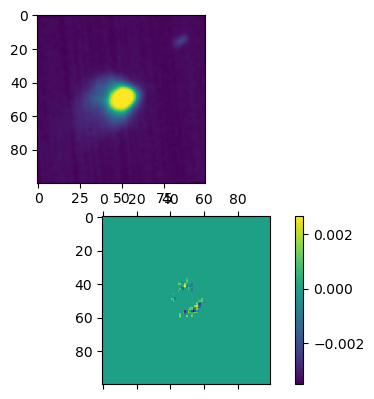

In [72]:
# image = data1.numpy().squeeze()
# image = np.transpose(image, (1,2,0))
# image = Image.fromarray(image, mode="RGB")
# image = image.convert(mode='L')
# image = np.array(image)

image = data1.numpy().squeeze()

# data = R.cpu().detach().numpy().squeeze()
data = R

fig, axs = plt.subplots(2)
axs[0].imshow(image)
heatmap = axs[1].matshow(data)
plt.colorbar(heatmap)
plt.show()